In [1]:
! pip install mne

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%ls

CommandLine.ipynb  Final_epochs_pre_ICA/  PreprocesamientoEEG.ipynb  README.md
eeg_functions.py   ICA_EEG.ipynb          __pycache__/


In [9]:
path = '/content/drive/MyDrive/SEED/EEG_emotion_classification/Final_epochs_pre_ICA/'
filename = 'P1E1-epo.fif'

In [7]:
from google.colab import drive
import mne
from mne.preprocessing import ICA, create_ecg_epochs, create_eog_epochs
from mne.viz import plot_topomap
import os
import numpy as np
import matplotlib.pyplot as plt
from eeg_functions import plot_simEEG_mne

# Deshacer corrección de línea base

Reading /content/drive/MyDrive/SEED/EEG_emotion_classification/Final_epochs_pre_ICA/P1E1-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     300.00 ms
        0 CTF compensation matrices available
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using matplotlib as 2D backend.


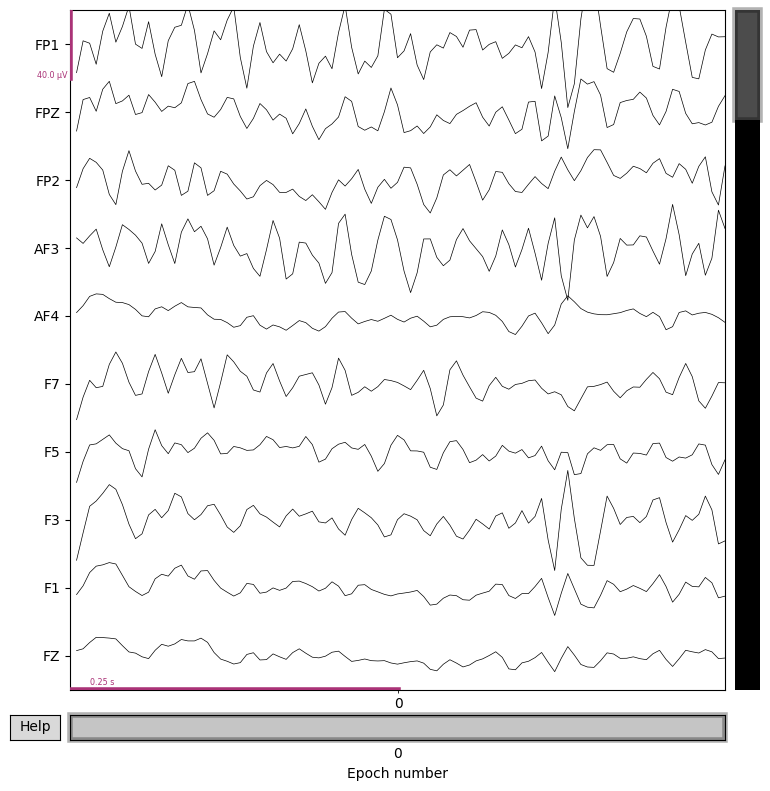

In [10]:
epochs = mne.read_epochs(os.path.join(path, filename), preload=True)
validate_epochs = epochs.copy()

epochs[0].plot(n_epochs=1, n_channels=10);

In [11]:
baseline = (-0.2, 0)

baseline_data = epochs.copy().crop(tmin=baseline[0], tmax=baseline[1]).get_data()

<ipython-input-11-4d11ae159e18>:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  baseline_data = epochs.copy().crop(tmin=baseline[0], tmax=baseline[1]).get_data()


In [12]:
baseline_data.shape

(13, 62, 201)

In [13]:
baseline_mean = baseline_data.mean(axis=(0, 2))

baseline_mean.shape

(62,)

In [14]:
baseline_mean_expanded = baseline_mean[np.newaxis, :, np.newaxis]
baseline_mean_expanded.shape

(1, 62, 1)

In [15]:
epochs._data += baseline_mean_expanded

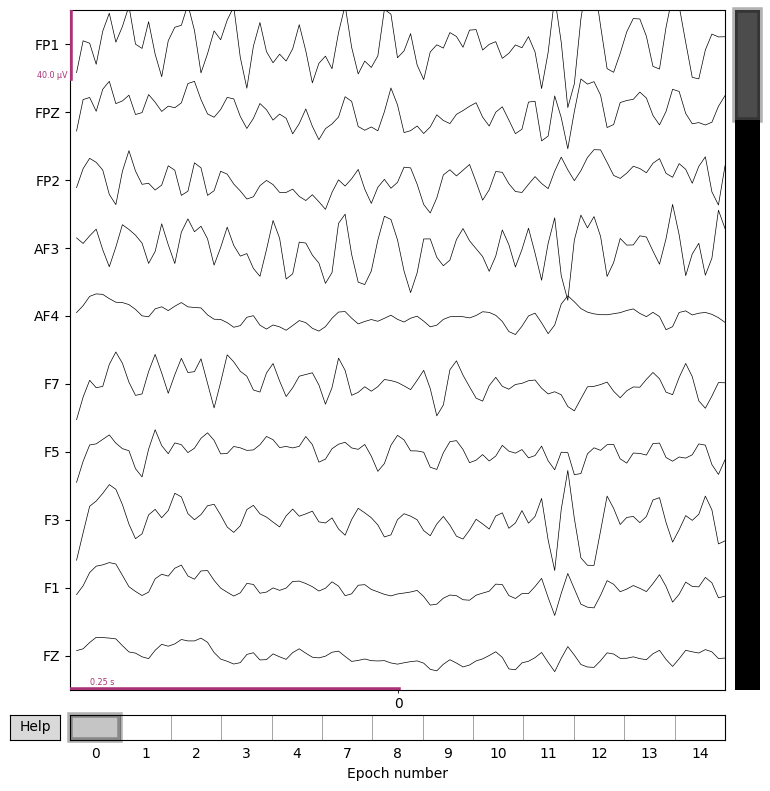

In [ ]:
epochs.plot(n_epochs=1, n_channels=10);

In [ ]:
validate_epochs == epochs

False

# Nuevo filtro pasa altas

In [16]:
epochs.filter(l_freq=1.0, h_freq=None)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



<ipython-input-16-686e7b0955ec>:1: RuntimeWarning: filter_length (3301) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq=1.0, h_freq=None)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


Number of events,13
Events,0: 11: 110: 111: 112: 113: 114: 12: 13: 14: 17: 18: 19: 1
Time range,-0.200 – 0.300 s
Baseline,-0.200 – 0.000 s


# Implementación de ICA

In [17]:
ica = ICA(random_state=97)
ica.fit(epochs)

Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 61 components


<ipython-input-17-bf7c1123feb9>:2: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 15.8s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,205 iterations on epochs (6513 samples)
ICA components,61
Available PCA components,62
Channel types,eeg
ICA components marked for exclusion,—


In [19]:
type(ica)

mne.preprocessing.ica.ICA

In [20]:
explained_var_ratio = ica.get_explained_variance_ratio(epochs)
for channel_type, ratio in explained_var_ratio.items():
    print(
        f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
    )

Fraction of eeg variance explained by all components: 1.0


In [21]:
component = 0

explained_var_ratio = ica.get_explained_variance_ratio(
    epochs, components=[component], ch_type="eeg"
)
# This time, print as percentage.
ratio_percent = round(100 * explained_var_ratio["eeg"])
print(
    f"Fraction of variance in EEG signal explained by component {component}: "
    f"{ratio_percent}%"
)

Fraction of variance in EEG signal explained by component 0: 37%


Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-22-a780910fc33e>:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  ica.plot_sources(epochs, show_scrollbars=False);


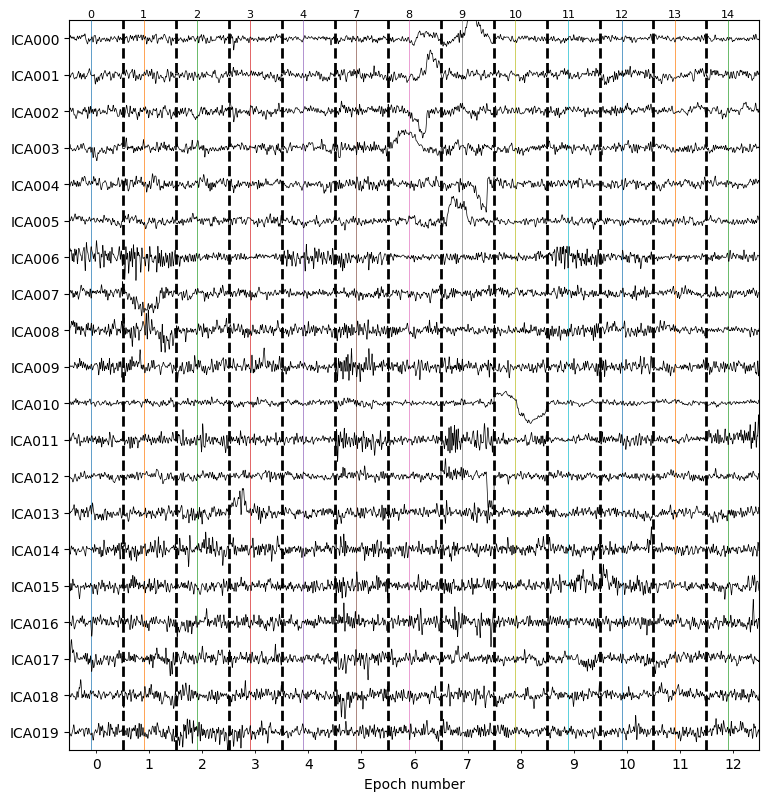

In [22]:
ica.plot_sources(epochs, show_scrollbars=False);

In [23]:
def topo_plot_epochs(epochs, title='Topoplot', vlim=(None, None), cmap='RdBu_r', contours=6):
    '''
    epochs: instancia de Epochs de MNE
    title: título del gráfico
    vlim: límites de color para el mapa topográfico
    cmap: mapa de colores
    contours: número de contornos en el mapa topográfico
    '''
    # Asegurarse de que las posiciones de los electrodos están en las épocas
    assert epochs.info['dig'] is not None, "Las posiciones de los electrodos no están en las épocas."

    # Extraer las posiciones de los electrodos
    pos = np.array([ch['loc'][:2] for ch in epochs.info['chs']])

    # Calcular los valores promedio de las épocas
    values = np.mean(epochs.get_data(), axis=(0, 2))  # Promedio sobre épocas y tiempo

    # Crear el gráfico topográfico
    fig, ax = plt.subplots(figsize=(8, 8))
    im, _ = plot_topomap(values, pos, axes=ax, show=False, cmap=cmap,
                         contours=contours, vmin=vlim[0], vmax=vlim[1])
    plt.colorbar(im)

    # Título
    plt.title(title)
    plt.show()

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mne.viz import plot_topomap

def topo_plot_ica(ica, component_idx, title='Topoplot', vlim=(None, None), cmap='RdBu_r', contours=6, head_rad=0.095, plot_rad=0.51):
    '''
    ica: instancia de ICA de MNE
    component_idx: índice del componente ICA que se va a trazar
    title: título del gráfico
    vlim: límites de color para el mapa topográfico (vmin, vmax)
    cmap: mapa de colores
    contours: número de contornos en el mapa topográfico
    head_rad: radio de la cabeza
    plot_rad: radio del área de trazado
    '''
    # Asegurarse de que las posiciones de los electrodos están en el objeto ICA
    assert ica.info['dig'] is not None, "Las posiciones de los electrodos no están en el objeto ICA."

    # Extraer las posiciones de los electrodos
    pos = np.array([ch['loc'][:2] for ch in ica.info['chs']])
    squeezefac = head_rad / plot_rad
    pos *= squeezefac  # Ajustar la escala de las posiciones de los electrodos

    # Extraer el patrón del componente ICA
    ica_patterns = ica.get_components()
    component_pattern = ica_patterns[:, component_idx]

    # Crear el gráfico topográfico
    fig, ax = plt.subplots(figsize=(4, 4))
    im, _ = plot_topomap(component_pattern, pos, axes=ax, show=False, cmap=cmap,
                         contours=contours, vlim=vlim, sphere=(0, 0, 0, head_rad))
    plt.colorbar(im)

    # Título
    plt.title(f'Componente ICA {component_idx}')
    plt.show()

In [25]:
ica_patterns = ica.get_components()

# Tomo los primeros 35 componentes independientes. Los últimos no suelen tener mucho impacto.
for component_idx in range(35):
  component_pattern = ica_patterns[:, component_idx]
  topo_plot_ica(ica, component_idx=component_idx)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ica_p
